HistGBR: RMSE=3,003,139 | MAE=1,686,683 | R2=0.593


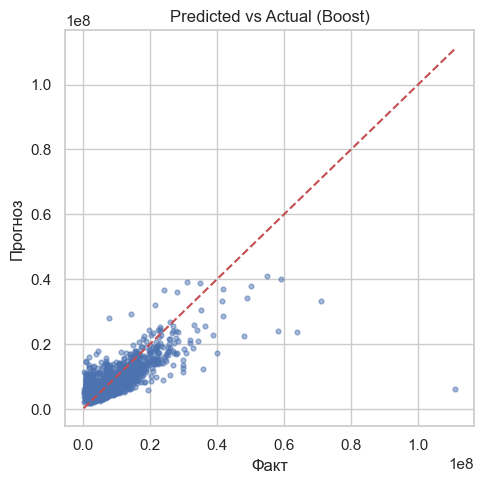

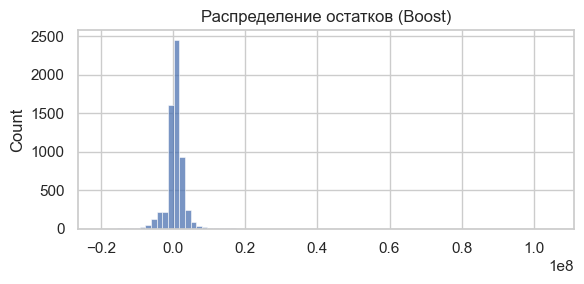

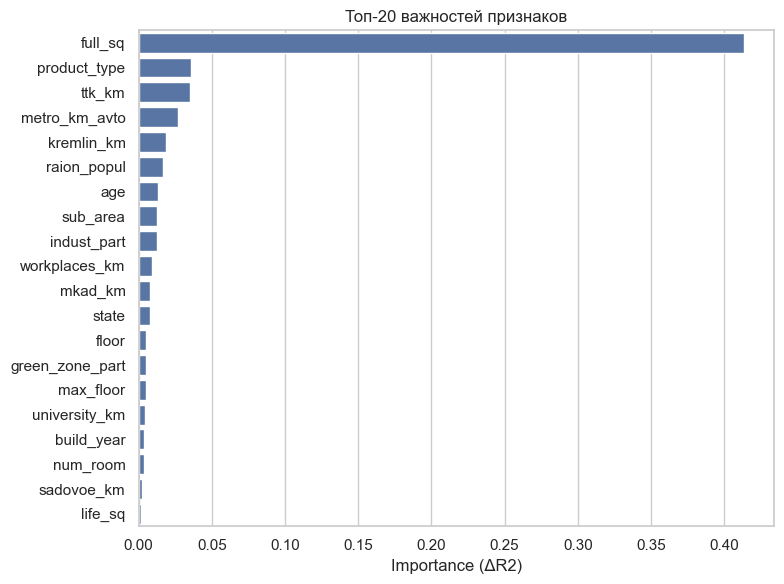

Пайплайн обучен и сохранен в переменной boost_fitted.
Модель сохранена: ./models/price_model_hgbr.joblib


In [6]:
# Полный прогон с нуля (реалэстейт)
import os, inspect
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.inspection import permutation_importance
from joblib import dump

sns.set(style="whitegrid")
RANDOM_STATE = 42

# 1) Загрузка
DATA_PATH = "./data/train.csv"
assert os.path.exists(DATA_PATH), f"Файл не найден: {DATA_PATH}"
df = pd.read_csv(DATA_PATH, parse_dates=["timestamp"])

# 2) Очистка
def clean_sberbank(df):
    df = df.copy().drop_duplicates()
    df = df[df["price_doc"].notna() & (df["price_doc"] > 100_000)]
    if "full_sq" in df.columns:
        df = df[(df["full_sq"] > 15) & (df["full_sq"] < 400)]
    if "life_sq" in df.columns and "full_sq" in df.columns:
        df.loc[df["life_sq"] > df["full_sq"], "life_sq"] = np.nan
        df.loc[df["life_sq"] < 10, "life_sq"] = np.nan
    if "kitch_sq" in df.columns and "full_sq" in df.columns:
        df.loc[df["kitch_sq"] > df["full_sq"], "kitch_sq"] = np.nan
        df.loc[df["kitch_sq"] < 3, "kitch_sq"] = np.nan
    if "floor" in df.columns:
        df.loc[df["floor"] <= 0, "floor"] = np.nan
    if "max_floor" in df.columns and "floor" in df.columns:
        df.loc[df["max_floor"] <= 0, "max_floor"] = np.nan
        mask = df["floor"].notna() & df["max_floor"].notna() & (df["floor"] > df["max_floor"])
        df.loc[mask, ["floor","max_floor"]] = np.nan
    if "build_year" in df.columns:
        df.loc[(df["build_year"] < 1850) | (df["build_year"] > 2025), "build_year"] = np.nan
    if "state" in df.columns:
        df.loc[~df["state"].isin([1,2,3,4]), "state"] = np.nan
    if "timestamp" in df.columns:
        df["year"]  = df["timestamp"].dt.year
        df["month"] = df["timestamp"].dt.month
        if "build_year" in df.columns:
            df["age"] = df["year"] - df["build_year"]
            df.loc[df["age"] < 0, "age"] = np.nan
    return df

df = clean_sberbank(df)

# 3) Фичи
planned_num = [
    "full_sq","life_sq","kitch_sq","num_room","floor","max_floor",
    "build_year","state","age",
    "raion_popul","green_zone_part","indust_part",
    "metro_km_avto","mkad_km","ttk_km","sadovoe_km","kremlin_km",
    "university_km","workplaces_km"
]
planned_cat = ["sub_area","product_type","material"]

num_features = [c for c in planned_num if c in df.columns]
cat_features = [c for c in planned_cat if c in df.columns]
feature_cols = num_features + cat_features

assert "price_doc" in df.columns
df_model = df.dropna(subset=["price_doc"]).copy()

# 4) Сплит и таргет (лог-таргет)
y = np.log1p(df_model["price_doc"].values)
X = df_model[feature_cols].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

# 5) Препроцессинг + модель
def make_ohe():
    return OneHotEncoder(handle_unknown="ignore",
                         sparse_output=False) if "sparse_output" in inspect.signature(OneHotEncoder).parameters \
                                              else OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), num_features),
        ("cat", Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                          ("ohe", make_ohe())]), cat_features)
    ]
)

boost_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", HistGradientBoostingRegressor(
        random_state=RANDOM_STATE,
        max_depth=6, learning_rate=0.05, max_iter=500,
        early_stopping=True, validation_fraction=0.1
    ))
])

# 6) Обучение и метрики (в рублях)
boost_pipeline.fit(X_train, y_train)
pred_log = boost_pipeline.predict(X_test)
y_true = np.expm1(y_test)
y_pred = np.expm1(pred_log)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae  = mean_absolute_error(y_true, y_pred)
r2   = r2_score(y_true, y_pred)
print(f"HistGBR: RMSE={rmse:,.0f} | MAE={mae:,.0f} | R2={r2:.3f}")

# 7) Графики: Predicted vs Actual и остатки
plt.figure(figsize=(5,5))
plt.scatter(y_true, y_pred, s=12, alpha=0.5)
mn, mx = float(min(y_true.min(), y_pred.min())), float(max(y_true.max(), y_pred.max()))
plt.plot([mn, mx], [mn, mx], 'r--')
plt.xlabel("Факт")
plt.ylabel("Прогноз")
plt.title("Predicted vs Actual (Boost)")
plt.tight_layout(); plt.show()

resid = y_true - y_pred
plt.figure(figsize=(6,3))
sns.histplot(resid, bins=80)
plt.title("Распределение остатков (Boost)")
plt.tight_layout(); plt.show()

# 8) Важности признаков (пермутационные по исходным колонкам X)
r = permutation_importance(
    boost_pipeline, X_test, y_test,
    n_repeats=5, random_state=RANDOM_STATE, scoring="r2"
)
imp = pd.Series(r.importances_mean, index=feature_cols).sort_values(ascending=False).head(20)

plt.figure(figsize=(8,6))
sns.barplot(x=imp.values, y=imp.index, color="#4C72B0")
plt.title("Топ-20 важностей признаков")
plt.xlabel("Importance (ΔR2)")
plt.ylabel("")
plt.tight_layout(); plt.show()

# 9) Сохраним обученный пайплайн и нужные объекты в памяти
boost_fitted = boost_pipeline  # для следующей ячейки
print("Пайплайн обучен и сохранен в переменной boost_fitted.")

# (опц.) Сохранение в файл
os.makedirs("./models", exist_ok=True)
dump(boost_fitted, "./models/price_model_hgbr.joblib")
print("Модель сохранена: ./models/price_model_hgbr.joblib")




In [7]:
import pandas as pd
import numpy as np

def predict_price(sample_dict, model_pipeline=boost_fitted,
                  feature_cols=feature_cols, df_reference=df):
    # Собираем полный ряд с нужными колонками
    row = {col: sample_dict.get(col, np.nan) for col in feature_cols}

    # Если можем — считаем age из build_year
    if "age" in feature_cols:
        by = row.get("build_year", np.nan)
        if (pd.isna(row.get("age", np.nan))) and pd.notna(by):
            ref_year = int(df_reference["year"].median()) if "year" in df_reference.columns else 2015
            row["age"] = ref_year - int(by)

    X_sample = pd.DataFrame([row], columns=feature_cols)
    pred_log = model_pipeline.predict(X_sample)[0]
    return float(np.expm1(pred_log))

# Пример: возьмем часть фич из теста (остальные заимпутятся)
example = {c: X_test.iloc[0][c] for c in feature_cols[:min(6, len(feature_cols))]}
print("Пример прогноза:", predict_price(example))

Пример прогноза: 7626608.233910354
